In [5]:
import yfinance as yf

tickers = ['SETFNIF50.NS', 'GOLDBEES.NS']
data = yf.download(tickers, start="2015-01-01")

print(data.columns)


C:\Users\JEEVAN\AppData\Local\Temp\ipykernel_26996\1259891651.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01")
[*********************100%***********************]  2 of 2 completed

MultiIndex([( 'Close',  'GOLDBEES.NS'),
            ( 'Close', 'SETFNIF50.NS'),
            (  'High',  'GOLDBEES.NS'),
            (  'High', 'SETFNIF50.NS'),
            (   'Low',  'GOLDBEES.NS'),
            (   'Low', 'SETFNIF50.NS'),
            (  'Open',  'GOLDBEES.NS'),
            (  'Open', 'SETFNIF50.NS'),
            ('Volume',  'GOLDBEES.NS'),
            ('Volume', 'SETFNIF50.NS')],
           names=['Price', 'Ticker'])


In [7]:
# Extract only the 'Close' prices
close = data.loc[:, ('Close', slice(None))]
close.columns = close.columns.droplevel(0)  # Flatten column names

# View output
print(close.head())


Ticker      GOLDBEES.NS  SETFNIF50.NS
Date                                 
2015-01-01    24.563499           NaN
2015-01-02    24.511999           NaN
2015-01-05    24.662001           NaN
2015-01-06    24.979000           NaN
2015-01-07    25.021999           NaN


In [8]:
returns = close.pct_change().dropna()
returns.head()


Ticker,GOLDBEES.NS,SETFNIF50.NS
Date,,
2015-07-24,-0.002769,-0.007940
2015-07-27,0.002843,-0.018836
2015-07-28,-0.001396,-0.002869
2015-07-29,-0.004280,0.004561
2015-07-30,-0.003136,0.005578


In [9]:
pip install hmmlearn


Note: you may need to restart the kernel to use updated packages.


In [10]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import matplotlib.pyplot as plt

# Convert Nifty ETF returns to numpy array for HMM
nifty_returns = returns['SETFNIF50.NS'].values.reshape(-1, 1)

# Fit HMM model with 3 regimes
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
model.fit(nifty_returns)

# Predict hidden states (regimes)
hidden_states = model.predict(nifty_returns)

# Add to DataFrame for visualization
returns['Regime'] = hidden_states


c:\Users\JEEVAN\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\JEEVAN\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\JEEVAN\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JEEVAN\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\JEEVAN\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

In [12]:
print(returns['Regime'].value_counts())


Regime
0    2345
2      83
1      45
Name: count, dtype: int64


In [14]:
aligned_close = data['Close']['SETFNIF50.NS'].loc[returns.index]


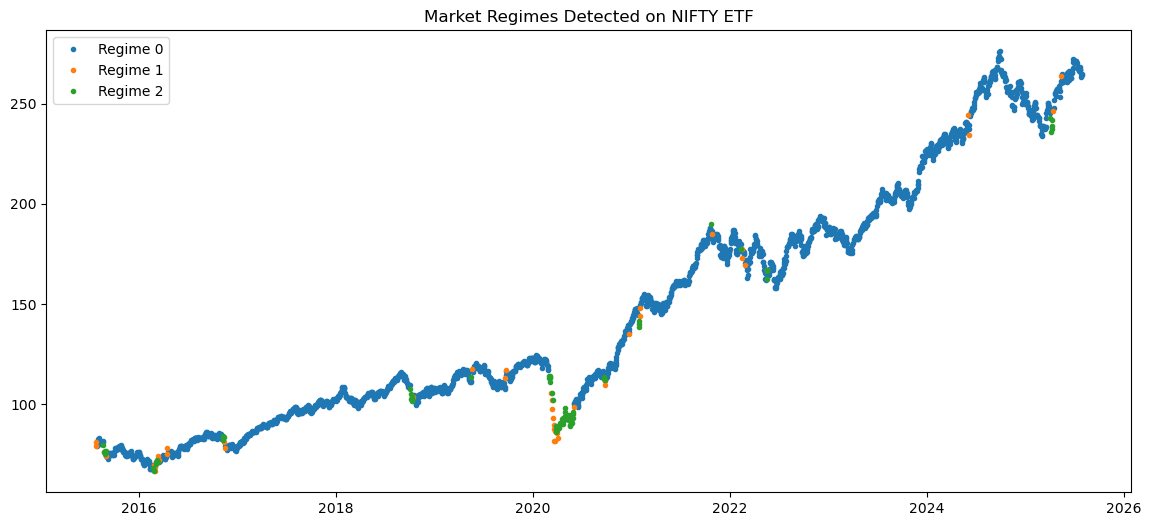

In [15]:
plt.figure(figsize=(14, 6))

aligned_close = data['Close']['SETFNIF50.NS'].loc[returns.index]  # align dates

for i in range(3):
    state = returns['Regime'] == i
    plt.plot(aligned_close.index[state], aligned_close[state], '.', label=f'Regime {i}')

plt.legend()
plt.title("Market Regimes Detected on NIFTY ETF")
plt.show()


In [16]:
# Calculate average return per regime
returns['Daily Return'] = aligned_close.pct_change()
regime_stats = returns.groupby('Regime')['Daily Return'].mean()
print(regime_stats)


Regime
0    0.000630
1   -0.003715
2   -0.000072
Name: Daily Return, dtype: float64


In [17]:
regime_map = {
    0: 'Bull',
    1: 'Sideways',
    2: 'Bear'
}
returns['Regime_Label'] = returns['Regime'].map(regime_map)


In [18]:
def signal(row):
    if row['Regime_Label'] == 'Bull':
        return 1   # Invest
    elif row['Regime_Label'] == 'Bear':
        return -1  # Avoid or Short
    else:
        return 0   # Stay neutral

returns['Signal'] = returns.apply(signal, axis=1)


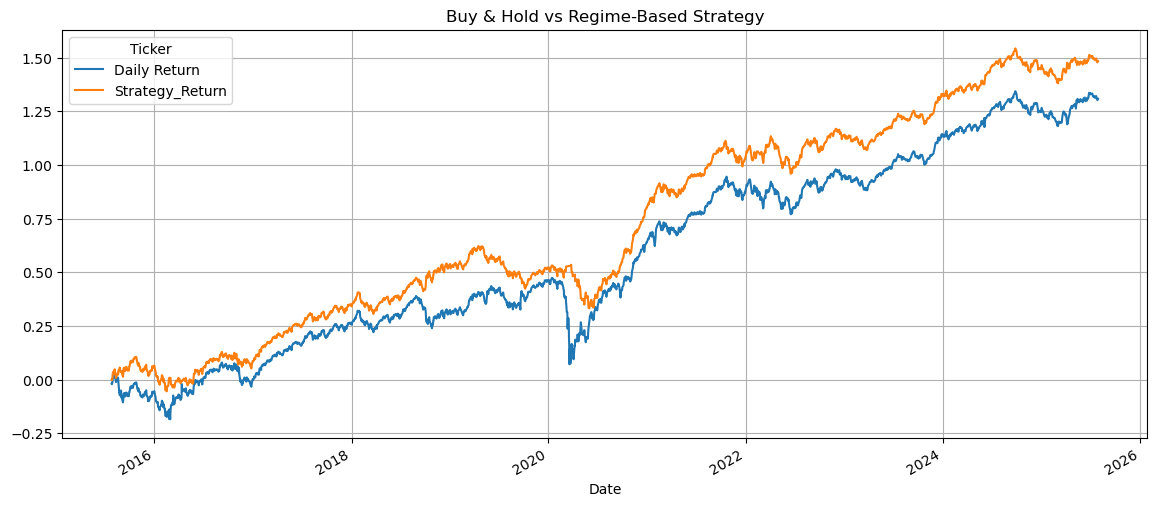

In [19]:
returns['Strategy_Return'] = returns['Daily Return'] * returns['Signal']
returns[['Daily Return', 'Strategy_Return']].cumsum().plot(figsize=(14,6))
plt.title('Buy & Hold vs Regime-Based Strategy')
plt.grid()
plt.show()


In [22]:
import pandas as pd

# Example data
data = {
    'regime': ['bull', 'bear', 'neutral', 'bull', 'bear']
}

# Create the DataFrame
returns_df = pd.DataFrame(data)


In [23]:
def get_allocation(regime):
    if regime == 'bull':
        return [0.8, 0.1, 0.1]  # Nifty, Gold, Cash
    elif regime == 'bear':
        return [0.3, 0.5, 0.2]
    else:
        return [0.5, 0.3, 0.2]

# Apply the allocation function
allocations = returns_df['regime'].apply(get_allocation)

# Convert to DataFrame
allocations_df = pd.DataFrame(
    allocations.tolist(),
    index=returns_df.index,
    columns=['Nifty', 'Gold', 'Cash']
)

allocations_df.head()


,Nifty,Gold,Cash
0,0.8,0.1,0.1
1,0.3,0.5,0.2
2,0.5,0.3,0.2
3,0.8,0.1,0.1
4,0.3,0.5,0.2


In [24]:
# Assuming you have this from earlier steps (returns per asset)
# Make sure the index matches `allocations_df`
# Example:
# returns = pd.DataFrame({ 'Nifty': ..., 'Gold': ..., 'Cash': ... }, index=returns_df.index)

portfolio_returns = (returns * allocations_df).sum(axis=1)
portfolio_returns.head()


2015-07-24 00:00:00    0
2015-07-27 00:00:00    0
2015-07-28 00:00:00    0
2015-07-29 00:00:00    0
2015-07-30 00:00:00    0
dtype: object

<Axes: title={'center': 'Cumulative Portfolio Returns'}>

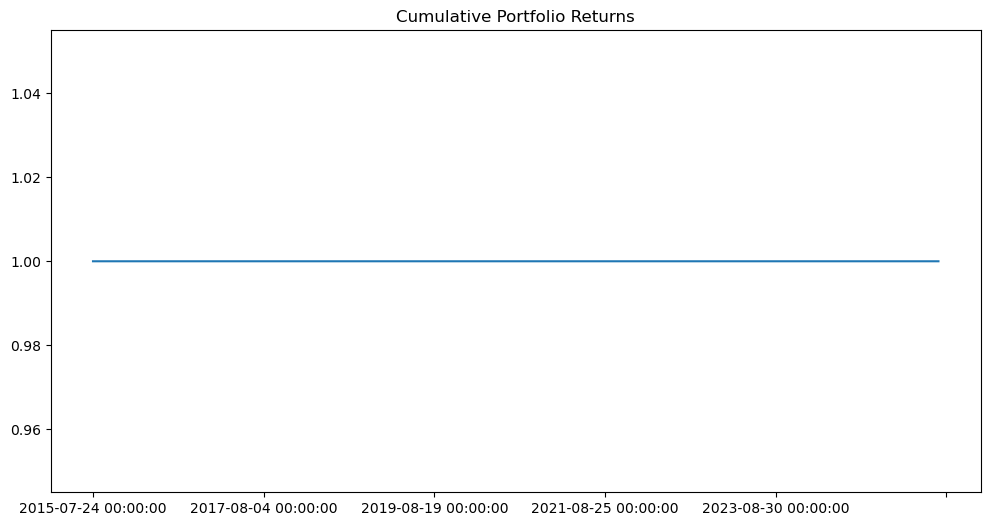

In [25]:
cumulative_returns = (1 + portfolio_returns).cumprod()
cumulative_returns.plot(figsize=(12, 6), title='Cumulative Portfolio Returns')


In [27]:
print(returns.columns)


Index(['GOLDBEES.NS', 'SETFNIF50.NS', 'Regime', 'Daily Return', 'Regime_Label',
       'Signal', 'Strategy_Return'],
      dtype='object', name='Ticker')


In [28]:
returns = returns.rename(columns={'SETFNIF50.NS': 'Nifty'})


Text(0.5, 1.0, 'Strategy vs Nifty Benchmark')

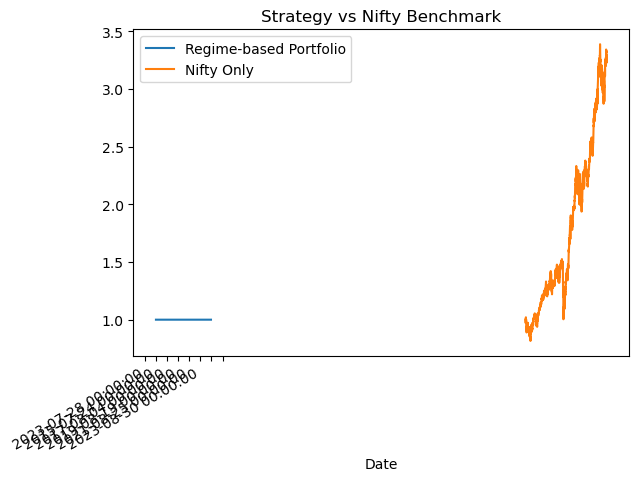

In [29]:
nifty_cum_returns = (1 + returns['Nifty']).cumprod()
cumulative_returns.plot(label='Regime-based Portfolio')
nifty_cum_returns.plot(label='Nifty Only')
plt.legend()
plt.title('Strategy vs Nifty Benchmark')


In [33]:
print(returns.columns)


Index(['GOLDBEES.NS', 'Nifty', 'Regime', 'Daily Return', 'Regime_Label',
       'Signal', 'Strategy_Return'],
      dtype='object', name='Ticker')


In [34]:
allocations_df = pd.DataFrame(
    allocations.tolist(),
    index=returns_df.index,
    columns=['Nifty', 'Gold', 'Cash']
)


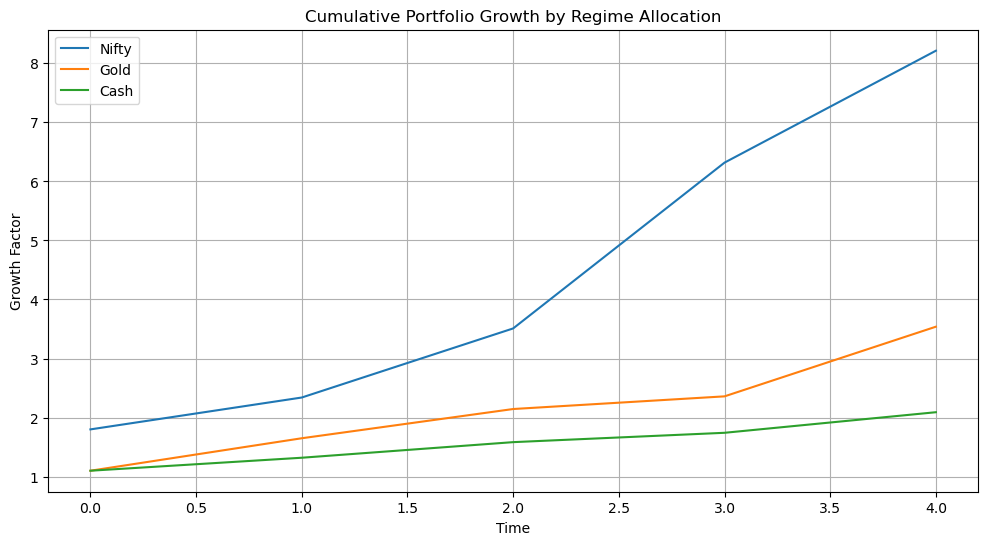

In [35]:
(allocations_df.add(1).cumprod()).plot(figsize=(12,6))
plt.title('Cumulative Portfolio Growth by Regime Allocation')
plt.ylabel('Growth Factor')
plt.xlabel('Time')
plt.grid(True)
plt.show()
